<a href="https://colab.research.google.com/github/peremartra/Tailoring-LLM-Architectures/blob/CH06/CH06/CH06_NB01_Layer_Mapping_Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Tailoring LLM Architectures**
## **Chapter 6: Layer Mapping Experiments**

### **Notebook 1: Solving the Depth Mismatch Problem**
by [Pere Martra](https://github.com/peremartra)

[![LinkedIn](https://img.shields.io/badge/LinkedIn-0077B5?style=flat&logo=linkedin&logoColor=white)](https://www.linkedin.com/in/pere-martra/) [![GitHub](https://img.shields.io/badge/GitHub-100000?style=flat&logo=github&logoColor=white)](https://github.com/peremartra) [![Hugging Face](https://img.shields.io/badge/🤗%20Hugging%20Face-blue)](https://huggingface.co/oopere)

---

**Colab Environment:** GPU T4
- **Model:** Qwen/Qwen2.5-0.5B (Teacher) + depth-pruned version (Student, 20 layers)
- **Expected Runtime:** 25-30 minutes

---

**What we'll accomplish:**
- Demonstrate the depth mismatch problem when computing L_Hidden with different layer counts
- Implement and compare two layer mapping strategies (Uniform vs Last-Layer)
- Show that Last-Layer mapping is superior (~2% improvement)
- Demonstrate that feature alignment provides crucial +4-5% recovery beyond logits-only KD
- Visualize the convergence of internal representations during training

## Section 0: Environment & Dependencies

In [2]:
from google.colab import drive
drive.mount('/content/drive')
print("✓ Drive mounted - you can sleep now!")

Mounted at /content/drive
✓ Drive mounted - you can sleep now!


In [3]:
# Install required packages
!pip install -q transformers accelerate datasets
!pip install -q optipfair  # For creating pruned model on-the-fly
!pip install -q matplotlib seaborn tqdm
!pip install -q lm_eval
!pip install -q langdetect
!pip install -q codecarbon

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 144.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.6/293.6 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.1/91.1 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 48.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.7/358.7 kB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
import torch, gc
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    TrainingArguments,
    Trainer
)
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm.auto import tqdm
from copy import deepcopy
import warnings

warnings.filterwarnings('ignore')

# Check PyTorch version and device
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

PyTorch version: 2.9.0+cu126
CUDA available: True
Using device: cuda


In [5]:
#Samples in the training dataset.
RECOVERY_SAMPLES = 2000
# Flag to skip benchmarks during development (set to True for final run)
RUN_FULL_BENCHMARKS = False
BENCHMARK_LIMIT = 500  #From 100 for quick testing to None for full evaluation
EPOCHS=5
LEARNING_RATE=2e-5  #1e-5


In [6]:
def set_seed(seed=42):
    """Set random seed for reproducibility"""
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

set_seed(42)
print("✓ Random seed set to 42")

✓ Random seed set to 42


In [7]:
# Download utils.py from GitHub repository
!wget -q https://raw.githubusercontent.com/peremartra/Rearchitecting-LLMs/main/utils.py

# Verify download
import os
if os.path.exists('utils.py'):
    print("✅ utils.py downloaded successfully")
else:
    print("❌ Failed to download utils.py")

from utils import (
    evaluate_metrics,  # Loss & Perplexity
    clear_gpu_cache
)

✅ utils.py downloaded successfully


## Section 1: Load Models and Create Pruned Student

In [8]:
MODEL_NAME = "google/gemma-3-270m"

print(f"Loading Teacher model: {MODEL_NAME}")
teacher_model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32,
    device_map="auto" if torch.cuda.is_available() else None
)

# Freeze teacher (we never update it)
teacher_model.eval()
for param in teacher_model.parameters():
    param.requires_grad = False

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Print architecture info
n_teacher_layers = len(teacher_model.model.layers)
hidden_dim = teacher_model.config.hidden_size

print(f"\n{'='*60}")
print(f"Teacher Model: {MODEL_NAME}")
print(f"{'='*60}")
print(f"Total layers: {n_teacher_layers}")
print(f"Hidden dimension: {hidden_dim}")
print(f"Total parameters: {teacher_model.num_parameters():,}")
print(f"Memory footprint: {teacher_model.get_memory_footprint() / 1e9:.2f} GB")
print(f"{'='*60}\n")

Loading Teacher model: google/gemma-3-270m


config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/536M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/133 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]


Teacher Model: google/gemma-3-270m
Total layers: 18
Hidden dimension: 640
Total parameters: 268,098,176
Memory footprint: 0.54 GB



## Section 2: Prepare Training Dataset

In [9]:
# Load SlimPajama dataset in streaming mode for efficiency
#print("Loading SlimPajama-627B dataset...")
#dataset = load_dataset(
#    "cerebras/SlimPajama-627B",
#    split="train",
#    streaming=True
#)

# Take a representative subset for our recovery process
#
#print(f"Selecting {RECOVERY_SAMPLES:,} samples for knowledge recovery...")

# Use streaming dataset's take method
#distillation_dataset = dataset.take(RECOVERY_SAMPLES)
#print(f"✓ Streaming dataset ready: {RECOVERY_SAMPLES:,} samples")

In [10]:
# # ALTERNATIVE DATASET: Cosmopedia
# # Uncomment this cell to use Cosmopedia instead of SlimPajama
#
print("Loading Cosmopedia dataset...")
dataset_name = "HuggingFaceTB/cosmopedia"
subsets = ["stories", "wikihow", "openstax", "web_samples_v1"]
samples_per_subset = int(RECOVERY_SAMPLES / 4)
num_samples = samples_per_subset * len(subsets)  # 15000 total

print(f"Loading {len(subsets)} subsets with {samples_per_subset:,} samples each...")
#
all_samples = []
for subset in subsets:
    print(f"  Loading {subset}...")
    subset_data = load_dataset(dataset_name, subset, split="train", streaming=True)
    subset_samples = list(subset_data.take(samples_per_subset))
    all_samples.extend(subset_samples)
    print(f"    ✓ {len(subset_samples):,} samples from {subset}")
#
print(f"✓ Total samples loaded: {len(all_samples):,}")
#
from datasets import Dataset
distillation_dataset = Dataset.from_dict({'text': [s['text'] for s in all_samples]})
print(f"✓ Cosmopedia dataset ready: {len(distillation_dataset):,} samples")

Loading Cosmopedia dataset...
Loading 4 subsets with 500 samples each...
  Loading stories...


README.md: 0.00B [00:00, ?B/s]

Resolving data files:   0%|          | 0/18 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/43 [00:00<?, ?it/s]

    ✓ 500 samples from stories
  Loading wikihow...


Resolving data files:   0%|          | 0/18 [00:00<?, ?it/s]

    ✓ 500 samples from wikihow
  Loading openstax...


Resolving data files:   0%|          | 0/18 [00:00<?, ?it/s]

    ✓ 500 samples from openstax
  Loading web_samples_v1...


Resolving data files:   0%|          | 0/18 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/139 [00:00<?, ?it/s]

    ✓ 500 samples from web_samples_v1
✓ Total samples loaded: 2,000
✓ Cosmopedia dataset ready: 2,000 samples


In [11]:
MAX_LENGTH = 512

def tokenize_function(examples):
    """Tokenize text samples for training"""
    texts = examples['text'] if isinstance(examples, dict) else examples
    return tokenizer(
        texts,
        truncation=True,
        padding="max_length",
        max_length=MAX_LENGTH,
        return_tensors="pt"
    )

print(f"✓ Tokenization function ready (max_length={MAX_LENGTH})")

✓ Tokenization function ready (max_length=512)


In [12]:
print("Preparing DataLoader...")

# Convert streaming dataset to list
print("  Converting streaming dataset to list...")
dataset_list = list(distillation_dataset)
texts = [item['text'] for item in dataset_list]

print(f"  Tokenizing {len(texts):,} samples...")
tokenized_data = []
batch_size = 1000
for i in tqdm(range(0, len(texts), batch_size), desc="Tokenizing"):
    batch_texts = texts[i:i+batch_size]
    batch_tokens = tokenizer(
        batch_texts,
        truncation=True,
        padding="max_length",
        max_length=MAX_LENGTH,
        return_tensors="pt"
    )
    tokenized_data.append(batch_tokens)

# Combine all batches
input_ids = torch.cat([batch['input_ids'] for batch in tokenized_data], dim=0)
attention_mask = torch.cat([batch['attention_mask'] for batch in tokenized_data], dim=0)

# Create TensorDataset and DataLoader
from torch.utils.data import TensorDataset
train_dataset = TensorDataset(input_ids, attention_mask)

BATCH_SIZE = 16
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

print(f"\n✓ DataLoader ready:")
print(f"  Total samples: {len(train_dataset):,}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Total batches: {len(train_dataloader):,}")

Preparing DataLoader...
  Converting streaming dataset to list...
  Tokenizing 2,000 samples...


Tokenizing:   0%|          | 0/2 [00:00<?, ?it/s]


✓ DataLoader ready:
  Total samples: 2,000
  Batch size: 16
  Total batches: 125


In [13]:
import optipfair as opf

print("Creating Student model with depth pruning...")

# IMPORTANT: Use deepcopy to avoid modifying the original model
student_model = deepcopy(teacher_model)
importance_scores = opf.analyze_layer_importance(student_model, train_dataloader, show_progress=True)

Creating Student model with depth pruning...


Processing batches: 100%|██████████| 125/125 [00:10<00:00, 12.02it/s]


In [14]:
LAYERS_TO_REMOVE = sorted(importance_scores.keys(), key=lambda x: importance_scores[x])[:4]
print (LAYERS_TO_REMOVE)

[9, 8, 14, 16]


In [15]:

student_model = opf.prune_model_depth(
    model=student_model,
    layer_indices=LAYERS_TO_REMOVE,
    show_progress=True,
)

# IMPORTANT: Unfreeze student parameters!
# The deepcopy inherited requires_grad=False from the frozen teacher
for param in student_model.parameters():
    param.requires_grad = True

# Get student info
n_student_layers = len(student_model.model.layers)

print(f"\n{'='*60}")
print(f"Student Model (Depth Pruned)")
print(f"{'='*60}")
print(f"Total layers: {n_student_layers} (removed {LAYERS_TO_REMOVE})")
print(f"Hidden dimension: {hidden_dim} (unchanged)")
print(f"Total parameters: {student_model.num_parameters():,}")
print(f"{'='*60}\n")

print(f"✓ Student has {n_student_layers} layers vs Teacher's {n_teacher_layers} layers")
print(f"✓ This creates the DEPTH MISMATCH problem we'll solve with layer mapping")
print(f"✓ Student parameters unfrozen and ready for training")

Removing layers: 100%|██████████| 18/18 [00:00<00:00, 221400.21it/s]


Student Model (Depth Pruned)
Total layers: 14 (removed [9, 8, 14, 16])
Hidden dimension: 640 (unchanged)
Total parameters: 245,803,648

✓ Student has 14 layers vs Teacher's 18 layers
✓ This creates the DEPTH MISMATCH problem we'll solve with layer mapping
✓ Student parameters unfrozen and ready for training


## Section 3: Implement Layer Mapping Strategies

In [16]:
def create_layer_map_uniform(n_student, n_teacher):
    """
    Uniform layer mapping: Distribute student layers proportionally across teacher layers

    Args:
        n_student: Number of student layers
        n_teacher: Number of teacher layers

    Returns:
        List of teacher layer indices for each student layer
    """
    teacher_indices = []
    for i in range(n_student):
        teacher_idx = int(i * n_teacher / n_student)
        teacher_indices.append(teacher_idx)
    return teacher_indices


def create_layer_map_last(n_student, n_teacher):
    """
    Last-layer alignment: Map student layers to the deepest teacher layers

    Args:
        n_student: Number of student layers
        n_teacher: Number of teacher layers

    Returns:
        List of teacher layer indices for each student layer
    """
    offset = n_teacher - n_student
    return [i + offset for i in range(n_student)]

def create_layer_map_original_indices(student_model, teacher_model, removed_layers):
    """
    Mapeo correcto para capas dispersas basado en índices originales
    """
    n_teacher = len(teacher_model.model.layers)

    # Reconstruir los índices originales del student
    original_indices = []
    teacher_idx = 0
    for i in range(n_teacher):
        if i not in removed_layers:
            original_indices.append(i)

    # El mapeo es directo: cada student layer mapea a su índice original
    layer_map = original_indices

    print(f"Original Teacher layers: {list(range(n_teacher))}")
    print(f"Removed layers: {sorted(removed_layers)}")
    print(f"Student original indices: {original_indices}")
    print(f"Mapping: {layer_map}")

    return layer_map

def create_layer_map_original_indices(student_model, teacher_model, removed_layers):
    """
    Mapeo correcto para capas dispersas basado en índices originales
    """
    n_teacher = len(teacher_model.model.layers)

    # Reconstruir los índices originales del student
    original_indices = []
    teacher_idx = 0
    for i in range(n_teacher):
        if i not in removed_layers:
            original_indices.append(i)

    # El mapeo es directo: cada student layer mapea a su índice original
    layer_map = original_indices

    print(f"Original Teacher layers: {list(range(n_teacher))}")
    print(f"Removed layers: {sorted(removed_layers)}")
    print(f"Student original indices: {original_indices}")
    print(f"Mapping: {layer_map}")

    return layer_map

# Test both strategies
print("Testing layer mapping strategies:")
print(f"Student layers: {n_student_layers}")
print(f"Teacher layers: {n_teacher_layers}")

uniform_map = create_layer_map_uniform(n_student_layers, n_teacher_layers)
last_map = create_layer_map_last(n_student_layers, n_teacher_layers)
layer_map = create_layer_map_original_indices(
    student_model,
    teacher_model,
    LAYERS_TO_REMOVE
)

print(f"\n✓ Uniform mapping: {uniform_map[:5]}... (showing first 5)")
print(f"✓ Last-layer mapping: {last_map[:5]}... (showing first 5)")



Testing layer mapping strategies:
Student layers: 14
Teacher layers: 18
Original Teacher layers: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
Removed layers: [8, 9, 14, 16]
Student original indices: [0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 15, 17]
Mapping: [0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 15, 17]

✓ Uniform mapping: [0, 1, 2, 3, 5]... (showing first 5)
✓ Last-layer mapping: [4, 5, 6, 7, 8]... (showing first 5)


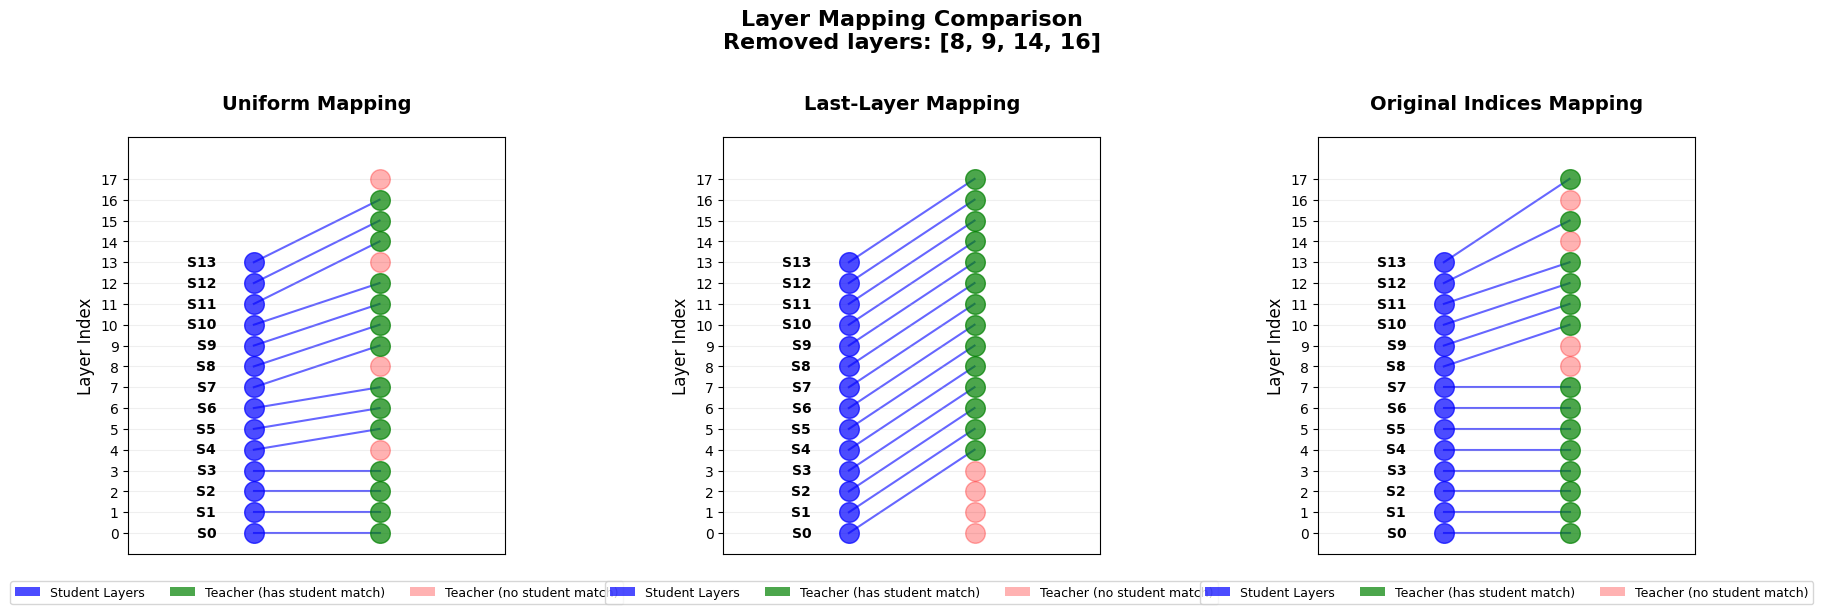

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_layer_mappings_comparison(
    n_student,
    n_teacher,
    removed_layers,
    uniform_map,
    last_map,
    original_map
):
    """
    Visualiza los tres tipos de mapeo en una comparativa clara
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    mappings = [
        ("Uniform Mapping", uniform_map),
        ("Last-Layer Mapping", last_map),
        ("Original Indices Mapping", original_map)
    ]

    for idx, (title, mapping) in enumerate(mappings):
        ax = axes[idx]

        # Config limits
        ax.set_xlim(-1, 2)
        ax.set_ylim(-1, max(n_teacher, n_student) + 1)

        # Draw student layers(left)
        student_x = 0
        for i in range(n_student):
            ax.scatter(student_x, i, s=200, c='blue', zorder=3, alpha=0.7)
            ax.text(student_x - 0.3, i, f'S{i}', fontsize=10,
                   ha='right', va='center', fontweight='bold')

        # Draw teacher layers (right)
        teacher_x = 1
        mapped_teachers = set(mapping)

        for i in range(n_teacher):
            color = 'green' if i in mapped_teachers else 'red'  # ✅ DINÁMICO
            alpha = 0.7 if i in mapped_teachers else 0.3
            ax.scatter(teacher_x, i, s=200, c=color, zorder=3, alpha=alpha)

        # Draw connections
        for student_idx, teacher_idx in enumerate(mapping):
          # Todas las conexiones son válidas - línea azul siempre
          ax.plot([student_x, teacher_x],
                [student_idx, teacher_idx],
                '-',  # línea sólida
                color='blue',
                linewidth=1.5,
                alpha=0.6,
                zorder=1)


        # Labels & Tittle
        ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
        ax.set_yticks(range(max(n_teacher, n_student)))
        ax.set_xticks([])
        ax.set_ylabel('Layer Index', fontsize=12)
        ax.grid(True, alpha=0.2, axis='y')

        # Legend
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='blue', alpha=0.7, label='Student Layers'),
            Patch(facecolor='green', alpha=0.7, label='Teacher (has student match)'),
            Patch(facecolor='red', alpha=0.3, label='Teacher (no student match)')  # ✅ CLARO
        ]
        ax.legend(handles=legend_elements, loc='upper center',
                 bbox_to_anchor=(0.5, -0.05), ncol=3, fontsize=9)

    plt.suptitle(f'Layer Mapping Comparison\nRemoved layers: {sorted(removed_layers)}',
                fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()


# ===== use visualization =====
visualize_layer_mappings_comparison(
    n_student=n_student_layers,
    n_teacher=n_teacher_layers,
    removed_layers=LAYERS_TO_REMOVE,
    uniform_map=uniform_map,
    last_map=last_map,
    original_map=layer_map
)

## Section 4: Implement Compound Loss

In [18]:
def compute_compound_loss(
    student_logits,
    teacher_logits,
    student_hiddens,
    teacher_hiddens,
    labels,
    layer_map,
    alpha=0.4,
    beta=0.4,
    gamma=0.2,
    temperature=2.0
):
    """
    Compound loss with Cosine Similarity for feature alignment.

    Uses cosine similarity instead of MSE to avoid scale issues:
    - MSE can produce values in the hundreds of thousands
    - Cosine similarity is normalized and bounded [0, 2]
    - Measures directional alignment, not magnitude
    """
    # 1. TASK LOSS (Cross-Entropy)
    shift_logits = student_logits[..., :-1, :].contiguous()
    shift_labels = labels[..., 1:].contiguous()
    loss_task = F.cross_entropy(
        shift_logits.view(-1, shift_logits.size(-1)),
        shift_labels.view(-1),
        ignore_index=-100
    )

    # 2. LOGITS LOSS (KL Divergence)
    student_soft = F.log_softmax(student_logits / temperature, dim=-1)
    teacher_soft = F.softmax(teacher_logits / temperature, dim=-1)

    student_soft = student_soft[..., :-1, :].contiguous()
    teacher_soft = teacher_soft[..., :-1, :].contiguous()

    loss_logits = F.kl_div(
        student_soft.view(-1, student_soft.size(-1)),
        teacher_soft.view(-1, teacher_soft.size(-1)),
        reduction='batchmean'
    ) * (temperature ** 2)

    # 3. HIDDEN STATES LOSS (Cosine Similarity)
    if gamma > 0:
      loss_hidden = 0.0
      num_aligned_layers = len(layer_map)

      for student_idx, teacher_idx in enumerate(layer_map):
          student_h = student_hiddens[student_idx]
          teacher_h = teacher_hiddens[teacher_idx]

          # Flatten: [batch * seq_len, hidden_dim]
          student_flat = student_h.reshape(-1, student_h.size(-1))
          teacher_flat = teacher_h.reshape(-1, teacher_h.size(-1))

          # Normalize vectors to unit length
          student_norm = F.normalize(student_flat, p=2, dim=1)
          teacher_norm = F.normalize(teacher_flat, p=2, dim=1)

          # Cosine similarity: dot product of normalized vectors
          # Range: [-1, 1], where 1 = perfectly aligned
          cos_sim = (student_norm * teacher_norm).sum(dim=1).mean()

          # Convert to loss: 1 - cos_sim
          # Range: [0, 2], where 0 = perfect alignment
          loss_hidden += (1 - cos_sim)

      loss_hidden = loss_hidden / num_aligned_layers
    else:
      loss_hidden = torch.tensor(0.0, device=student_logits.device)

    # COMBINE ALL LOSSES
    total_loss = alpha * loss_task + beta * loss_logits + gamma * loss_hidden

    loss_dict = {
        'total': total_loss.item(),
        'task': loss_task.item(),
        'logits': loss_logits.item(),
        'hidden': loss_hidden.item()
    }

    return total_loss, loss_dict

## Section 5: Training Loop Implementation

In [19]:
import time

def train_student(
    student_model,
    teacher_model,
    dataloader,
    layer_map,
    alpha=0.4,
    beta=0.4,
    gamma=0.2,
    temperature=2.0,
    epochs=3,
    learning_rate=1e-5,
    experiment_name="experiment",
    accumulation_steps=4
):
    """
    Train student model with compound loss and gradient accumulation

    Returns:
        trained_model, loss_history, training_time_seconds
    """
    optimizer = torch.optim.AdamW(student_model.parameters(), lr=learning_rate)

    student_model.train()
    teacher_model.eval()

    request_hidden_states = (gamma > 0)

    loss_history = {'total': [], 'task': [], 'logits': [], 'hidden': []}
    epoch_times = []  # Tiempo por epoch



    print(f"\n{'='*60}")
    print(f"Starting Training: {experiment_name}")
    print(f"{'='*60}")
    print(f"Epochs: {epochs}")
    print(f"Learning rate: {learning_rate}")
    print(f"Loss weights: α={alpha}, β={beta}, γ={gamma}, T={temperature}")
    print(f"Gradient Accumulation Steps: {accumulation_steps}")
    print(f"Effective Batch Size: {dataloader.batch_size * accumulation_steps}")
    print(f"{'='*60}\n")

    total_start_time = time.time()

    for epoch in range(epochs):
        epoch_start_time = time.time()

        epoch_losses = {'total': [], 'task': [], 'logits': [], 'hidden': []}
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")

        accumulated_losses = {'total': 0.0, 'task': 0.0, 'logits': 0.0, 'hidden': 0.0}
        accumulation_counter = 0

        for batch_idx, (input_ids, attention_mask) in enumerate(progress_bar):
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = input_ids.clone()

            student_outputs = student_model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                output_hidden_states=request_hidden_states
            )

            with torch.no_grad():
                teacher_outputs = teacher_model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    output_hidden_states=request_hidden_states
                )

            student_hiddens = (student_outputs.hidden_states[1:]
                             if request_hidden_states else None)
            teacher_hiddens = (teacher_outputs.hidden_states[1:]
                             if request_hidden_states else None)

            loss, loss_dict = compute_compound_loss(
                student_logits=student_outputs.logits,
                teacher_logits=teacher_outputs.logits,
                student_hiddens=student_hiddens,
                teacher_hiddens=teacher_hiddens,
                labels=labels,
                layer_map=layer_map,
                alpha=alpha, beta=beta, gamma=gamma, temperature=temperature
            )

            scaled_loss = loss / accumulation_steps
            scaled_loss.backward()

            for key in accumulated_losses:
                accumulated_losses[key] += loss_dict[key]
            accumulation_counter += 1

            if (batch_idx + 1) % accumulation_steps == 0:
                torch.nn.utils.clip_grad_norm_(student_model.parameters(), max_norm=1.0)
                optimizer.step()
                optimizer.zero_grad()

                avg_losses = {k: v / accumulation_counter for k, v in accumulated_losses.items()}
                for key in avg_losses:
                    epoch_losses[key].append(avg_losses[key])

                progress_bar.set_postfix({
                    'loss': f"{avg_losses['total']:.4f}",
                    'task': f"{avg_losses['task']:.4f}",
                    'logits': f"{avg_losses['logits']:.4f}",
                    'hidden': f"{avg_losses['hidden']:.4f}"
                })

                accumulated_losses = {'total': 0.0, 'task': 0.0, 'logits': 0.0, 'hidden': 0.0}
                accumulation_counter = 0

        if accumulation_counter > 0:
            torch.nn.utils.clip_grad_norm_(student_model.parameters(), max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()

            avg_losses = {k: v / accumulation_counter for k, v in accumulated_losses.items()}
            for key in avg_losses:
                epoch_losses[key].append(avg_losses[key])

        for key in epoch_losses:
            if epoch_losses[key]:
                avg_loss = np.mean(epoch_losses[key])
                loss_history[key].append(avg_loss)

        epoch_time = time.time() - epoch_start_time
        epoch_times.append(epoch_time)

        print(f"Epoch {epoch+1} avg losses - "
              f"Total: {loss_history['total'][-1]:.4f}, "
              f"Task: {loss_history['task'][-1]:.4f}, "
              f"Logits: {loss_history['logits'][-1]:.4f}, "
              f"Hidden: {loss_history['hidden'][-1]:.4f} "
              f"[{epoch_time:.1f}s]")

    total_time = time.time() - total_start_time

    # Añadir tiempos al historial
    loss_history['epoch_times_seconds'] = epoch_times
    loss_history['total_time_seconds'] = total_time

    print(f"\n✓ Training completed: {experiment_name}")
    print(f"  Total time: {total_time:.1f}s ({total_time/60:.1f} min)")
    print(f"  Avg time per epoch: {np.mean(epoch_times):.1f}s")

    return student_model, loss_history

In [20]:
def train_student_advanced(
    student_model,
    teacher_model,
    dataloader,
    layer_map,
    # Loss weights
    alpha=0.1,           # Task loss
    beta=0.8,            # Skew KLD (logits)
    gamma=0.05,          # Trajectory loss (hidden states)
    delta=0.05,          # FDD derivative loss
    temperature=2.0,
    skew_alpha=0.5,      # Skew interpolation factor
    # Training params
    epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    experiment_name="experiment",
    accumulation_steps=4
):
    """
    Train student model with Advanced Compound Loss (Skew KLD + FDD).
    """
    optimizer = torch.optim.AdamW(student_model.parameters(), lr=learning_rate)

    student_model.train()
    teacher_model.eval()

    # Decide if we need hidden states (required if using trajectory OR derivative loss)
    request_hidden_states = (gamma > 0 or delta > 0)

    loss_history = {
        'total': [], 'task': [], 'logits': [],
        'trajectory': [], 'derivative': []
    }
    epoch_times = []

    print(f"\n{'='*60}")
    print(f"Starting Training: {experiment_name}")
    print(f"{'='*60}")
    print(f"Epochs: {epochs}")
    print(f"Learning rate: {learning_rate}")
    print(f"Loss weights: α={alpha}, β={beta}, γ={gamma}, δ={delta}")
    print(f"Temperature: {temperature}, Skew α: {skew_alpha}")
    print(f"Hidden states computation: {'ENABLED' if request_hidden_states else 'DISABLED'}")
    print(f"Gradient Accumulation Steps: {accumulation_steps}")
    print(f"Effective Batch Size: {dataloader.batch_size * accumulation_steps}")
    print(f"{'='*60}\n")

    total_start_time = time.time()

    for epoch in range(epochs):
        epoch_start_time = time.time()

        epoch_losses = {k: [] for k in loss_history.keys()}
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")

        accumulated_losses = {k: 0.0 for k in loss_history.keys()}
        accumulation_counter = 0

        for batch_idx, (input_ids, attention_mask) in enumerate(progress_bar):
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = input_ids.clone()

            # Student forward pass
            student_outputs = student_model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                output_hidden_states=request_hidden_states
            )

            # Teacher forward pass (no gradients)
            with torch.no_grad():
                teacher_outputs = teacher_model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    output_hidden_states=request_hidden_states
                )

            # Prepare hidden states (None if not needed)
            student_hiddens = (student_outputs.hidden_states[1:]
                             if request_hidden_states else None)
            teacher_hiddens = (teacher_outputs.hidden_states[1:]
                             if request_hidden_states else None)

            # Compute advanced compound loss
            loss, loss_dict = compute_compound_loss_advanced(
                student_logits=student_outputs.logits,
                teacher_logits=teacher_outputs.logits,
                student_hiddens=student_hiddens,
                teacher_hiddens=teacher_hiddens,
                labels=labels,
                layer_map=layer_map,
                alpha=alpha,
                beta=beta,
                gamma=gamma,
                delta=delta,
                temperature=temperature,
                skew_alpha=skew_alpha
            )

            # Gradient accumulation
            scaled_loss = loss / accumulation_steps
            scaled_loss.backward()

            for key in accumulated_losses:
                accumulated_losses[key] += loss_dict[key]
            accumulation_counter += 1

            # Optimizer step
            if (batch_idx + 1) % accumulation_steps == 0:
                torch.nn.utils.clip_grad_norm_(student_model.parameters(), max_norm=1.0)
                optimizer.step()
                optimizer.zero_grad()

                avg_losses = {k: v / accumulation_counter for k, v in accumulated_losses.items()}
                for key in avg_losses:
                    epoch_losses[key].append(avg_losses[key])

                progress_bar.set_postfix({
                    'loss': f"{avg_losses['total']:.4f}",
                    'task': f"{avg_losses['task']:.4f}",
                    'logits': f"{avg_losses['logits']:.4f}",
                    'traj': f"{avg_losses['trajectory']:.4f}",
                    'deriv': f"{avg_losses['derivative']:.4f}"
                })

                accumulated_losses = {k: 0.0 for k in loss_history.keys()}
                accumulation_counter = 0

        # Handle remaining batches
        if accumulation_counter > 0:
            torch.nn.utils.clip_grad_norm_(student_model.parameters(), max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()

            avg_losses = {k: v / accumulation_counter for k, v in accumulated_losses.items()}
            for key in avg_losses:
                epoch_losses[key].append(avg_losses[key])

        # Record epoch averages
        for key in epoch_losses:
            if epoch_losses[key]:
                loss_history[key].append(np.mean(epoch_losses[key]))

        epoch_time = time.time() - epoch_start_time
        epoch_times.append(epoch_time)

        print(f"Epoch {epoch+1} avg losses - "
              f"Total: {loss_history['total'][-1]:.4f}, "
              f"Task: {loss_history['task'][-1]:.4f}, "
              f"Logits: {loss_history['logits'][-1]:.4f}, "
              f"Traj: {loss_history['trajectory'][-1]:.4f}, "
              f"Deriv: {loss_history['derivative'][-1]:.4f} "
              f"[{epoch_time:.1f}s]")

    total_time = time.time() - total_start_time
    loss_history['epoch_times_seconds'] = epoch_times
    loss_history['total_time_seconds'] = total_time

    print(f"\n✓ Training completed: {experiment_name}")
    print(f"  Total time: {total_time:.1f}s ({total_time/60:.1f} min)")
    print(f"  Avg time per epoch: {np.mean(epoch_times):.1f}s")

    return student_model, loss_history


def compute_compound_loss_advanced(
    student_logits,      # [batch, seq_len, vocab_size]
    teacher_logits,      # [batch, seq_len, vocab_size]
    student_hiddens,     # List of [batch, seq_len, hidden_dim] or None
    teacher_hiddens,     # List of [batch, seq_len, hidden_dim] or None
    labels,              # [batch, seq_len]
    layer_map,           # List of teacher indices for each student layer
    alpha=0.1,           # weight for task loss
    beta=0.8,            # weight for logits loss (Skew KLD)
    gamma=0.1,           # weight for hidden trajectory loss
    delta=0.1,           # weight for FDD derivative loss
    temperature=2.0,     # temperature for soft labels
    skew_alpha=0.1       # interpolation factor for Skew KLD (0=Forward, 1=Reverse)
):
    """
    Advanced compound loss combining state-of-the-art techniques:

    1. Task Loss: Standard cross-entropy with hard labels
    2. Skew KLD: Interpolates between Forward and Reverse KLD (DistiLLM-2)
       - Forward KLD (α=0): Student covers all teacher modes (mean-seeking)
       - Reverse KLD (α=1): Student focuses on high-confidence modes (mode-seeking)
       - Skew (α=0.1): Best of both worlds, numerically stable
    3. Trajectory Loss: Cosine similarity between hidden states (standard feature KD)
    4. FDD Derivative Loss: Aligns the "rate of change" between consecutive layers
       - Forces student to learn HOW to transform representations, not just WHAT to produce
       - Critical for depth-pruned models that must take "bigger steps" with fewer layers

    Reference:
    - Skew KLD: DistiLLM-2 (2024)
    - FDD: Feature Dynamics Distillation, ACL 2025
    """
    device = student_logits.device

    # =========================================================================
    # 1. TASK LOSS (Cross-Entropy with hard labels)
    # =========================================================================
    shift_logits = student_logits[..., :-1, :].contiguous()
    shift_labels = labels[..., 1:].contiguous()

    loss_task = F.cross_entropy(
        shift_logits.view(-1, shift_logits.size(-1)),
        shift_labels.view(-1),
        ignore_index=-100
    )

    # =========================================================================
    # 2. SKEW KLD (Interpolated Divergence for Logits)
    # =========================================================================
    # Standard softmax with temperature
    with torch.no_grad():
        student_probs = F.softmax(student_logits[..., :-1, :] / temperature, dim=-1)
        teacher_probs = F.softmax(teacher_logits[..., :-1, :] / temperature, dim=-1)

        # Skew: interpolate between teacher and student distributions
        # When skew_alpha=0.1: 90% teacher + 10% student (slight mode-seeking bias)
        mixed_probs = skew_alpha * student_probs + (1 - skew_alpha) * teacher_probs

    # KL divergence against the mixed target
    student_log_probs = F.log_softmax(student_logits[..., :-1, :] / temperature, dim=-1)
    kl_elementwise = student_probs * (student_log_probs - torch.log(mixed_probs + 1e-9))
    loss_logits = kl_elementwise.sum(dim=-1).mean() * (temperature ** 2)

    # =========================================================================
    # 3. TRAJECTORY LOSS (Cosine Similarity of Hidden States)
    # =========================================================================
    # Standard feature alignment - matches "where" the student is in representation space
    # Only compute if gamma > 0 and we have hidden states
    if gamma > 0 and student_hiddens is not None and teacher_hiddens is not None:
        loss_trajectory = 0.0
        for student_idx, teacher_idx in enumerate(layer_map):
            student_h = student_hiddens[student_idx]
            teacher_h = teacher_hiddens[teacher_idx]

            # Flatten and normalize
            student_flat = student_h.reshape(-1, student_h.size(-1))
            teacher_flat = teacher_h.reshape(-1, teacher_h.size(-1))
            student_norm = F.normalize(student_flat, p=2, dim=1)
            teacher_norm = F.normalize(teacher_flat, p=2, dim=1)

            # Cosine similarity loss: 1 - cos_sim (0 = perfect alignment)
            cos_sim = (student_norm * teacher_norm).sum(dim=1).mean()
            loss_trajectory += (1 - cos_sim)

        loss_trajectory = loss_trajectory / len(layer_map)
    else:
        loss_trajectory = torch.tensor(0.0, device=device)

    # =========================================================================
    # 4. FDD DERIVATIVE LOSS (Feature Dynamics Distillation)
    # =========================================================================
    # Matches the "velocity" of representation change between consecutive layers
    # Key insight: In residual networks, x_{l+1} = x_l + F(x_l)
    # The delta F(x_l) represents how much the layer transforms the representation
    # A depth-pruned student must learn to make larger, more efficient transformations
    # Only compute if delta > 0 and we have hidden states
    loss_derivative = torch.tensor(0.0, device=device)

    if delta > 0 and student_hiddens is not None and teacher_hiddens is not None:
        num_derivatives = 0

        for student_idx in range(len(layer_map) - 1):
            teacher_idx = layer_map[student_idx]
            teacher_idx_next = layer_map[student_idx + 1]

            # Student delta: change between consecutive student layers
            student_delta = student_hiddens[student_idx + 1] - student_hiddens[student_idx]

            # Teacher delta: change between corresponding teacher layers
            teacher_delta = teacher_hiddens[teacher_idx_next] - teacher_hiddens[teacher_idx]

            # Flatten and normalize the deltas
            student_delta_flat = student_delta.reshape(-1, student_delta.size(-1))
            teacher_delta_flat = teacher_delta.reshape(-1, teacher_delta.size(-1))

            student_delta_norm = F.normalize(student_delta_flat, p=2, dim=1)
            teacher_delta_norm = F.normalize(teacher_delta_flat, p=2, dim=1)

            # Cosine similarity of derivatives
            cos_sim_deriv = (student_delta_norm * teacher_delta_norm).sum(dim=1).mean()
            loss_derivative += (1 - cos_sim_deriv)
            num_derivatives += 1

        if num_derivatives > 0:
            loss_derivative = loss_derivative / num_derivatives

    # =========================================================================
    # COMBINE ALL LOSSES
    # =========================================================================
    total_loss = (
        alpha * loss_task +
        beta * loss_logits +
        gamma * loss_trajectory +
        delta * loss_derivative
    )

    loss_dict = {
        'total': total_loss.item(),
        'task': loss_task.item(),
        'logits': loss_logits.item(),
        'trajectory': loss_trajectory.item(),
        'derivative': loss_derivative.item()
    }

    return total_loss, loss_dict

# Code for Evaluations

In [21]:
class DictDataLoader:
    """Wrapper to convert TensorDataset tuples to dictionaries"""
    def __init__(self, dataloader):
        self.dataloader = dataloader

    def __iter__(self):
        for input_ids, attention_mask in self.dataloader:
            yield {
                'input_ids': input_ids,
                'attention_mask': attention_mask
            }

    def __len__(self):
        return len(self.dataloader)

# Wrap the existing dataloader
eval_dataloader = DictDataLoader(train_dataloader)


## Section 6: Experiment A - Layer Mapping Comparison (Logits-Only)

In [22]:
clear_gpu_cache()

In [23]:
print("="*60)
print("EXPERIMENT A: Comparing Layer Mapping Strategies")
print("Configuration: Logits-Only KD (no hidden state alignment)")
print("="*60)

# Create fresh student model
student_uniform = deepcopy(student_model)

# Create uniform layer mapping
uniform_mapping = create_layer_map_uniform(n_student_layers, n_teacher_layers)

# Train with logits-only (gamma=0.0)
student_uniform_trained, history_uniform = train_student(
    student_model=student_uniform,
    teacher_model=teacher_model,
    dataloader=train_dataloader,
    layer_map=uniform_mapping,
    alpha=0.5,
    beta=0.5,
    gamma=0.0,  # No hidden state alignment
    temperature=2.0,
    epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    experiment_name="Uniform Mapping + Logits-Only"
)

EXPERIMENT A: Comparing Layer Mapping Strategies
Configuration: Logits-Only KD (no hidden state alignment)

Starting Training: Uniform Mapping + Logits-Only
Epochs: 5
Learning rate: 2e-05
Loss weights: α=0.5, β=0.5, γ=0.0, T=2.0
Gradient Accumulation Steps: 4
Effective Batch Size: 64



Epoch 1/5:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 1 avg losses - Total: 3.4274, Task: 4.0463, Logits: 2.8077, Hidden: 0.0000 [48.7s]


Epoch 2/5:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 2 avg losses - Total: 2.6370, Task: 3.5261, Logits: 1.7484, Hidden: 0.0000 [48.4s]


Epoch 3/5:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 3 avg losses - Total: 2.4425, Task: 3.3484, Logits: 1.5363, Hidden: 0.0000 [48.5s]


Epoch 4/5:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 4 avg losses - Total: 2.3481, Task: 3.2104, Logits: 1.4857, Hidden: 0.0000 [48.6s]


Epoch 5/5:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 5 avg losses - Total: 2.2654, Task: 3.0670, Logits: 1.4624, Hidden: 0.0000 [48.6s]

✓ Training completed: Uniform Mapping + Logits-Only
  Total time: 242.8s (4.0 min)
  Avg time per epoch: 48.6s


In [24]:
# Evaluate Teacher (baseline)
print("Evaluating Teacher...")
teacher_metrics = evaluate_metrics(teacher_model, eval_dataloader, device=device)
teacher_loss = teacher_metrics['loss']
teacher_ppl = teacher_metrics['perplexity']

# Evaluate Pruned Student (no training)
print("Evaluating Pruned Student (no training)...")
student_pruned = deepcopy(student_model)
student_metrics = evaluate_metrics(student_pruned, eval_dataloader, device=device)
student_loss = student_metrics['loss']
student_ppl = student_metrics['perplexity']

# Evaluate trained students
print("Evaluating Uniform + Logits-only...")
uniform_metrics = evaluate_metrics(student_uniform_trained, eval_dataloader, device=device)
uniform_loss = uniform_metrics['loss']
uniform_ppl = uniform_metrics['perplexity']



Evaluating Teacher...


Evaluating: 100%|██████████| 125/125 [00:11<00:00, 10.46it/s]


Evaluating Pruned Student (no training)...


Evaluating: 100%|██████████| 125/125 [00:10<00:00, 11.57it/s]


Evaluating Uniform + Logits-only...


Evaluating: 100%|██████████| 125/125 [00:10<00:00, 11.58it/s]


In [25]:
# Create fresh student model
student_last = deepcopy(student_model)

# Create last-layer mapping
last_mapping = create_layer_map_last(n_student_layers, n_teacher_layers)

# Train with logits-only (gamma=0.0)
student_last_trained, history_last = train_student(
    student_model=student_last,
    teacher_model=teacher_model,
    dataloader=train_dataloader,
    layer_map=last_mapping,
    alpha=0.5,
    beta=0.5,
    gamma=0.0,  # No hidden state alignment
    temperature=2.0,
    epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    experiment_name="Last-Layer Mapping + Logits-Only"
)


Starting Training: Last-Layer Mapping + Logits-Only
Epochs: 5
Learning rate: 2e-05
Loss weights: α=0.5, β=0.5, γ=0.0, T=2.0
Gradient Accumulation Steps: 4
Effective Batch Size: 64



Epoch 1/5:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 1 avg losses - Total: 3.4242, Task: 4.0365, Logits: 2.8117, Hidden: 0.0000 [48.4s]


Epoch 2/5:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 2 avg losses - Total: 2.6168, Task: 3.5162, Logits: 1.7191, Hidden: 0.0000 [48.5s]


Epoch 3/5:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 3 avg losses - Total: 2.4642, Task: 3.3732, Logits: 1.5546, Hidden: 0.0000 [48.5s]


Epoch 4/5:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 4 avg losses - Total: 2.3754, Task: 3.2440, Logits: 1.5077, Hidden: 0.0000 [48.5s]


Epoch 5/5:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 5 avg losses - Total: 2.2953, Task: 3.1064, Logits: 1.4852, Hidden: 0.0000 [48.5s]

✓ Training completed: Last-Layer Mapping + Logits-Only
  Total time: 242.4s (4.0 min)
  Avg time per epoch: 48.5s


In [26]:
print("Evaluating Last-Layer + Logits-only...")
last_metrics = evaluate_metrics(student_last_trained, eval_dataloader, device=device)
last_loss = last_metrics['loss']
last_ppl = last_metrics['perplexity']



Evaluating Last-Layer + Logits-only...


Evaluating: 100%|██████████| 125/125 [00:10<00:00, 11.58it/s]


In [27]:
# Create fresh student model
student_selected = deepcopy(student_model)

# Create last-layer mapping
selected_mapping = create_layer_map_original_indices(
    student_selected,
    teacher_model,
    LAYERS_TO_REMOVE
)

# Train with logits-only (gamma=0.0)
student_selected_trained, history_last = train_student(
    student_model=student_selected,
    teacher_model=teacher_model,
    dataloader=train_dataloader,
    layer_map=selected_mapping,
    alpha=0.5,
    beta=0.5,
    gamma=0.0,  # No hidden state alignment
    temperature=2.0,
    epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    experiment_name="Selected-Layer Mapping + Logits-Only"
)

Original Teacher layers: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
Removed layers: [8, 9, 14, 16]
Student original indices: [0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 15, 17]
Mapping: [0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 15, 17]

Starting Training: Selected-Layer Mapping + Logits-Only
Epochs: 5
Learning rate: 2e-05
Loss weights: α=0.5, β=0.5, γ=0.0, T=2.0
Gradient Accumulation Steps: 4
Effective Batch Size: 64



Epoch 1/5:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 1 avg losses - Total: 3.4513, Task: 4.0664, Logits: 2.8373, Hidden: 0.0000 [48.9s]


Epoch 2/5:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 2 avg losses - Total: 2.6382, Task: 3.5287, Logits: 1.7481, Hidden: 0.0000 [48.6s]


Epoch 3/5:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 3 avg losses - Total: 2.4624, Task: 3.3660, Logits: 1.5590, Hidden: 0.0000 [48.5s]


Epoch 4/5:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 4 avg losses - Total: 2.3561, Task: 3.2094, Logits: 1.5035, Hidden: 0.0000 [48.5s]


Epoch 5/5:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 5 avg losses - Total: 2.2866, Task: 3.0879, Logits: 1.4857, Hidden: 0.0000 [48.6s]

✓ Training completed: Selected-Layer Mapping + Logits-Only
  Total time: 243.1s (4.1 min)
  Avg time per epoch: 48.6s


In [28]:
print("Evaluating Selected-Layer + Logits-only...")
selected_metrics = evaluate_metrics(student_selected_trained, eval_dataloader, device=device)
selected_loss = selected_metrics['loss']
selected_ppl = selected_metrics['perplexity']


Evaluating Selected-Layer + Logits-only...


Evaluating: 100%|██████████| 125/125 [00:10<00:00, 11.56it/s]


## Section 7: Experiment B - Adding Feature Alignment

In [29]:
print("\n" + "="*60)
print("EXPERIMENT B: Adding Feature Alignment")
print("Configuration: Last-Layer Mapping + Full Compound Loss")
print("="*60)

# Create fresh student model
student_features = deepcopy(student_model)

# Use last-layer mapping (winner from Experiment A)
last_mapping = create_layer_map_last(n_student_layers, n_teacher_layers)

# Train with FULL compound loss (including hidden states)
student_features_trained, history_features = train_student(
    student_model=student_features,
    teacher_model=teacher_model,
    dataloader=train_dataloader,
    layer_map=last_mapping,
    alpha=0.4,
    beta=0.4,
    gamma=0.2,  # NOW we include hidden state alignment
    temperature=2.0,
    epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    experiment_name="Last-Layer + Features"
)


EXPERIMENT B: Adding Feature Alignment
Configuration: Last-Layer Mapping + Full Compound Loss

Starting Training: Last-Layer + Features
Epochs: 5
Learning rate: 2e-05
Loss weights: α=0.4, β=0.4, γ=0.2, T=2.0
Gradient Accumulation Steps: 4
Effective Batch Size: 64



Epoch 1/5:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 1 avg losses - Total: 2.7852, Task: 4.0291, Logits: 2.7793, Hidden: 0.3117 [49.4s]


Epoch 2/5:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 2 avg losses - Total: 2.1658, Task: 3.5270, Logits: 1.7339, Hidden: 0.2936 [49.4s]


Epoch 3/5:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 3 avg losses - Total: 2.0175, Task: 3.3533, Logits: 1.5424, Hidden: 0.2861 [49.5s]


Epoch 4/5:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 4 avg losses - Total: 1.9394, Task: 3.2089, Logits: 1.4990, Hidden: 0.2831 [49.4s]


Epoch 5/5:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 5 avg losses - Total: 1.8956, Task: 3.1104, Logits: 1.4919, Hidden: 0.2820 [49.4s]

✓ Training completed: Last-Layer + Features
  Total time: 247.0s (4.1 min)
  Avg time per epoch: 49.4s


In [30]:
print("Evaluating Last-Layer + Features...")
features_metrics = evaluate_metrics(student_features_trained, eval_dataloader, device=device)
features_loss = features_metrics['loss']
features_ppl = features_metrics['perplexity']

Evaluating Last-Layer + Features...


Evaluating: 100%|██████████| 125/125 [00:10<00:00, 11.54it/s]


In [31]:
print("\n" + "="*60)
print("Configuration: Selected-Layer Mapping + Full Compound Loss")
print("="*60)

# Create fresh student model
student_sel_features = deepcopy(student_model)

# Train with FULL compound loss (including hidden states)
student_sel_features_trained, history_sel_features = train_student(
    student_model=student_sel_features,
    teacher_model=teacher_model,
    dataloader=train_dataloader,
    layer_map=selected_mapping,
    alpha=0.4,
    beta=0.4,
    gamma=0.2,  # NOW we include hidden state alignment
    temperature=2.0,
    epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    experiment_name="Selected-Layer + Features"
)


Configuration: Selected-Layer Mapping + Full Compound Loss

Starting Training: Selected-Layer + Features
Epochs: 5
Learning rate: 2e-05
Loss weights: α=0.4, β=0.4, γ=0.2, T=2.0
Gradient Accumulation Steps: 4
Effective Batch Size: 64



Epoch 1/5:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 1 avg losses - Total: 2.7318, Task: 4.0328, Logits: 2.7952, Hidden: 0.0298 [49.8s]


Epoch 2/5:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 2 avg losses - Total: 2.1216, Task: 3.5402, Logits: 1.7620, Hidden: 0.0236 [49.3s]


Epoch 3/5:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 3 avg losses - Total: 1.9803, Task: 3.3734, Logits: 1.5708, Hidden: 0.0221 [49.4s]


Epoch 4/5:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 4 avg losses - Total: 1.9105, Task: 3.2415, Logits: 1.5245, Hidden: 0.0216 [49.4s]


Epoch 5/5:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 5 avg losses - Total: 1.8588, Task: 3.1224, Logits: 1.5115, Hidden: 0.0217 [49.4s]

✓ Training completed: Selected-Layer + Features
  Total time: 247.2s (4.1 min)
  Avg time per epoch: 49.4s


In [32]:
print("Evaluating Selected-Layer + Features...")
sel_features_metrics = evaluate_metrics(student_sel_features_trained, eval_dataloader, device=device)
sel_features_loss = sel_features_metrics['loss']
sel_features_ppl = sel_features_metrics['perplexity']

Evaluating Selected-Layer + Features...


Evaluating: 100%|██████████| 125/125 [00:10<00:00, 11.61it/s]


## Section 8: Experiment C - Advanced KD (Skew KLD + FDD)


In [33]:
print("\n" + "="*60)
print("EXPERIMENT C: Advanced Knowledge Distillation")
print("Configuration: Uniform-Layer Mapping + Skew KLD + FDD")
print("="*60)

# Create fresh student model
student_uni_advanced = deepcopy(student_model)

# Unfreeze parameters (inherited frozen from teacher)
for param in student_uni_advanced.parameters():
    param.requires_grad = True




EXPERIMENT C: Advanced Knowledge Distillation
Configuration: Uniform-Layer Mapping + Skew KLD + FDD


In [34]:
# Train with Advanced KD
student_uni_advanced_trained, history_advanced = train_student_advanced(
    student_model=student_uni_advanced,
    teacher_model=teacher_model,
    dataloader=train_dataloader,
    layer_map=uniform_mapping,
    alpha=0.2,           # Task loss weight
    beta=0.3,            # Skew KLD weight
    gamma=0.3,           # Trajectory (hidden) weight
    delta=0.2,           # FDD derivative weight
    temperature=2.0,
    skew_alpha=0.5,      # Slight mode-seeking bias
    epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    experiment_name="Uniform Layers Advanced KD (Skew KLD + FDD)"
)


Starting Training: Uniform Layers Advanced KD (Skew KLD + FDD)
Epochs: 5
Learning rate: 2e-05
Loss weights: α=0.2, β=0.3, γ=0.3, δ=0.2
Temperature: 2.0, Skew α: 0.5
Hidden states computation: ENABLED
Gradient Accumulation Steps: 4
Effective Batch Size: 64



Epoch 1/5:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 1 avg losses - Total: 1.0931, Task: 3.9135, Logits: 0.7217, Traj: 0.1087, Deriv: 0.3101 [54.0s]


Epoch 2/5:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 2 avg losses - Total: 0.9131, Task: 3.2338, Logits: 0.6033, Traj: 0.0981, Deriv: 0.2787 [53.9s]


Epoch 3/5:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 3 avg losses - Total: 0.8623, Task: 3.0214, Logits: 0.5825, Traj: 0.0960, Deriv: 0.2733 [54.0s]


Epoch 4/5:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 4 avg losses - Total: 0.8434, Task: 2.9578, Logits: 0.5675, Traj: 0.0942, Deriv: 0.2693 [54.0s]


Epoch 5/5:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 5 avg losses - Total: 0.8198, Task: 2.8717, Logits: 0.5500, Traj: 0.0917, Deriv: 0.2642 [54.1s]

✓ Training completed: Uniform Layers Advanced KD (Skew KLD + FDD)
  Total time: 269.9s (4.5 min)
  Avg time per epoch: 54.0s


In [35]:
# Evaluate Advanced KD
print("Evaluating Advanced KD (Skew KLD + FDD)...")
advanced_uni_metrics = evaluate_metrics(student_uni_advanced_trained, eval_dataloader, device=device)
advanced_uni_loss = advanced_uni_metrics['loss']
advanced_uni_ppl = advanced_uni_metrics['perplexity']

Evaluating Advanced KD (Skew KLD + FDD)...


Evaluating: 100%|██████████| 125/125 [00:10<00:00, 11.51it/s]


In [36]:
print("\n" + "="*60)
print("EXPERIMENT C: Advanced Knowledge Distillation")
print("Configuration: Selected-Layer Mapping + Skew KLD + FDD")
print("="*60)

# Create fresh student model
student_sel_advanced = deepcopy(student_model)

# Unfreeze parameters (inherited frozen from teacher)
for param in student_sel_advanced.parameters():
    param.requires_grad = True

# Use last-layer mapping (winner from Experiment A)
layer_mapping = create_layer_map_original_indices(
    student_sel_advanced,
    teacher_model,
    LAYERS_TO_REMOVE
)



EXPERIMENT C: Advanced Knowledge Distillation
Configuration: Selected-Layer Mapping + Skew KLD + FDD
Original Teacher layers: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
Removed layers: [8, 9, 14, 16]
Student original indices: [0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 15, 17]
Mapping: [0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 15, 17]


In [37]:
# Train with Advanced KD
student_sel_advanced_trained, history_advanced = train_student_advanced(
    student_model=student_sel_advanced,
    teacher_model=teacher_model,
    dataloader=train_dataloader,
    layer_map=layer_mapping,
    alpha=0.2,           # Task loss weight
    beta=0.3,            # Skew KLD weight
    gamma=0.3,           # Trajectory (hidden) weight
    delta=0.2,           # FDD derivative weight
    temperature=2.0,
    skew_alpha=0.5,      # Slight mode-seeking bias
    epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    experiment_name="Selected Layers Advanced KD (Skew KLD + FDD)"
)


Starting Training: Selected Layers Advanced KD (Skew KLD + FDD)
Epochs: 5
Learning rate: 2e-05
Loss weights: α=0.2, β=0.3, γ=0.3, δ=0.2
Temperature: 2.0, Skew α: 0.5
Hidden states computation: ENABLED
Gradient Accumulation Steps: 4
Effective Batch Size: 64



Epoch 1/5:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 1 avg losses - Total: 1.0200, Task: 3.8960, Logits: 0.7206, Traj: 0.0326, Deriv: 0.0772 [54.0s]


Epoch 2/5:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 2 avg losses - Total: 0.8637, Task: 3.2974, Logits: 0.6079, Traj: 0.0283, Deriv: 0.0672 [54.5s]


Epoch 3/5:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 3 avg losses - Total: 0.8062, Task: 3.0547, Logits: 0.5804, Traj: 0.0272, Deriv: 0.0648 [54.2s]


Epoch 4/5:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 4 avg losses - Total: 0.7688, Task: 2.9076, Logits: 0.5572, Traj: 0.0260, Deriv: 0.0621 [54.1s]


Epoch 5/5:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 5 avg losses - Total: 0.7362, Task: 2.7891, Logits: 0.5287, Traj: 0.0252, Deriv: 0.0592 [54.2s]

✓ Training completed: Selected Layers Advanced KD (Skew KLD + FDD)
  Total time: 270.9s (4.5 min)
  Avg time per epoch: 54.2s


In [38]:
# Evaluate Advanced KD
print("Evaluating Advanced KD (Skew KLD + FDD)...")
advanced_sel_metrics = evaluate_metrics(student_sel_advanced_trained, eval_dataloader, device=device)
advanced_sel_loss = advanced_sel_metrics['loss']
advanced_sel_ppl = advanced_sel_metrics['perplexity']

Evaluating Advanced KD (Skew KLD + FDD)...


Evaluating: 100%|██████████| 125/125 [00:10<00:00, 11.53it/s]


## Section 9: Evaluation and Comparison

In [39]:
# Calculate recovery rates
def recovery_rate(teacher_ppl, pruned_ppl, recovered_ppl):
    """Calculate recovery rate as percentage"""
    degradation = pruned_ppl - teacher_ppl
    recovery = pruned_ppl - recovered_ppl
    return (recovery / degradation) * 100 if degradation > 0 else 0




In [40]:
uniform_recovery = recovery_rate(teacher_ppl, student_ppl, uniform_ppl)
last_recovery = recovery_rate(teacher_ppl, student_ppl, last_ppl)
selected_recovery = recovery_rate(teacher_ppl, student_ppl, selected_ppl)
features_recovery = recovery_rate(teacher_ppl, student_ppl, features_ppl)
sel_features_recovery = recovery_rate(teacher_ppl, student_ppl, sel_features_ppl)
advanced_sel_recovery = recovery_rate(teacher_ppl, student_ppl, advanced_sel_ppl)
advanced_uni_recovery = recovery_rate(teacher_ppl, student_ppl, advanced_uni_ppl)

# Print results table
print("\n" + "="*80)
print("EVALUATION RESULTS")
print("="*80)
print(f"{'Model':<40} {'Loss':>10} {'Perplexity':>12} {'Recovery':>12}")
print("-"*80)
print(f"{'Teacher (Original)':<40} {teacher_loss:>10.4f} {teacher_ppl:>12.2f} {'100.0%':>12}")
print(f"{'Student (Pruned, no training)':<40} {student_loss:>10.4f} {student_ppl:>12.2f} {'0.0%':>12}")
print("-"*80)
print(f"{'Uniform + Logits-only':<40} {uniform_loss:>10.4f} {uniform_ppl:>12.2f} {f'{uniform_recovery:.1f}%':>12}")
print(f"{'Last-Layer + Logits-only':<40} {last_loss:>10.4f} {last_ppl:>12.2f} {f'{last_recovery:.1f}%':>12}")
print(f"{'Selected-Layer + Logits-only':<40} {selected_loss:>10.4f} {selected_ppl:>12.2f} {f'{selected_recovery:.1f}%':>12}")
print(f"{'Last-Layer + Features (Cosine)':<40} {features_loss:>10.4f} {features_ppl:>12.2f} {f'{features_recovery:.1f}%':>12}")
print(f"{'Selected-Layer + Features (Cosine)':<40} {sel_features_loss:>10.4f} {sel_features_ppl:>12.2f} {f'{sel_features_recovery:.1f}%':>12}")
print(f"{'Uniform  (Skew KLD + FDD)':<40} {advanced_uni_loss:>10.4f} {advanced_uni_ppl:>12.2f} {f'{advanced_uni_recovery:.1f}%':>12}")
print(f"{'Selected  (Skew KLD + FDD)':<40} {advanced_sel_loss:>10.4f} {advanced_sel_ppl:>12.2f} {f'{advanced_sel_recovery:.1f}%':>12}")
print("="*80)


EVALUATION RESULTS
Model                                          Loss   Perplexity     Recovery
--------------------------------------------------------------------------------
Teacher (Original)                           2.5627        12.97       100.0%
Student (Pruned, no training)                4.8038       121.97         0.0%
--------------------------------------------------------------------------------
Uniform + Logits-only                        3.0497        21.11        92.5%
Last-Layer + Logits-only                     3.0726        21.60        92.1%
Selected-Layer + Logits-only                 3.0739        21.63        92.1%
Last-Layer + Features (Cosine)               3.0719        21.58        92.1%
Selected-Layer + Features (Cosine)           3.0884        21.94        91.8%
Uniform  (Skew KLD + FDD)                    2.9189        18.52        94.9%
Selected  (Skew KLD + FDD)                   2.8608        17.48        95.9%


In [45]:
selected_ppl

np.float64(32.84253016112999)

In [ ]:
# Section 9: Benchmark Evaluation
if RUN_FULL_BENCHMARKS:
    from utils import model_evaluation

    # Define benchmark tasks
    BENCHMARK_TASKS = [
        "arc_easy",
        "winogrande",
        "hellaswag",
        "lambada_openai",
        "piqa"
    ]

    print("="*70)
    print("BENCHMARK EVALUATION")
    print(f"Tasks: {BENCHMARK_TASKS}")
    print(f"Limit: {BENCHMARK_LIMIT if BENCHMARK_LIMIT else 'Full dataset'}")
    print("="*70)

    # Store all benchmark results
    benchmark_results = {}

    # Models to evaluate
    models_to_benchmark = {
        "teacher": teacher_model,
        "student_pruned": student_pruned,
        "uniform_logits_only": student_uniform_trained,
        "last_layer_logits_only": student_last_trained,
        "last_layer_features": student_features_trained,
        "advanced_kd": student_advanced_trained
    }

    for model_name, model in models_to_benchmark.items():
        print(f"\n{'='*70}")
        print(f"Evaluating: {model_name}")
        print("="*70)

        try:
            results = model_evaluation(
                model_obj=model,
                tokenizer=tokenizer,
                tasks=BENCHMARK_TASKS,
                device=device,
                limit=BENCHMARK_LIMIT,
                batch_size=16 #4
            )
            benchmark_results[model_name] = results

            # Print summary for this model
            print(f"\n{model_name} results:")
            for task, metrics in results.items():
                print(f"  {task}: {metrics}")

        except Exception as e:
            print(f"Error evaluating {model_name}: {e}")
            benchmark_results[model_name] = {"error": str(e)}

        # Clear cache between models
        clear_gpu_cache()

    # Display comparison table
    print("\n" + "="*90)
    print("BENCHMARK COMPARISON TABLE")
    print("="*90)

    # Header
    header = f"{'Model':<25}"
    for task in BENCHMARK_TASKS:
        header += f"{task:<14}"
    print(header)
    print("-"*90)

    # Rows
    for model_name, results in benchmark_results.items():
        row = f"{model_name:<25}"
        for task in BENCHMARK_TASKS:
            if task in results and "error" not in results:
                # Get accuracy or acc_norm depending on task
                metrics = results[task]
                if "acc_norm" in metrics:
                    val = float(metrics["acc_norm"])
                elif "accuracy" in metrics:
                    val = float(metrics["accuracy"])
                else:
                    val = 0.0
                row += f"{val:.4f}        "
            else:
                row += f"{'N/A':<14}"
        print(row)

    print("="*90)

else:
    print("⚠️ Benchmark evaluation skipped (RUN_FULL_BENCHMARKS = False)")
    benchmark_results = {}

BENCHMARK EVALUATION
Tasks: ['arc_easy', 'winogrande', 'hellaswag', 'lambada_openai', 'piqa']
Limit: Full dataset

Evaluating: teacher
Starting lm-eval on model 'google/gemma-3-270m' for tasks: ['arc_easy', 'winogrande', 'hellaswag', 'lambada_openai', 'piqa']



Tasks grouped by few-shot: {0: ['arc_easy', 'winogrande', 'hellaswag', 'lambada_openai', 'piqa']} (full dataset)
Task-level few-shot config: {'arc_easy': 0, 'winogrande': 0, 'hellaswag': 0, 'lambada_openai': 0, 'piqa': 0}

Evaluating 5 task(s) with 0-shot learning...


README.md: 0.00B [00:00, ?B/s]

ARC-Easy/train-00000-of-00001.parquet:   0%|          | 0.00/331k [00:00<?, ?B/s]

ARC-Easy/test-00000-of-00001.parquet:   0%|          | 0.00/346k [00:00<?, ?B/s]

ARC-Easy/validation-00000-of-00001.parqu(…):   0%|          | 0.00/86.1k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2251 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2376 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/570 [00:00<?, ? examples/s]

README.md: 0.00B [00:00, ?B/s]

winogrande_xl/train-00000-of-00001.parqu(…):   0%|          | 0.00/2.06M [00:00<?, ?B/s]

winogrande_xl/test-00000-of-00001.parque(…):   0%|          | 0.00/118k [00:00<?, ?B/s]

winogrande_xl/validation-00000-of-00001.(…):   0%|          | 0.00/85.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/40398 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1767 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1267 [00:00<?, ? examples/s]

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/24.4M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/6.11M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/6.32M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/39905 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10003 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10042 [00:00<?, ? examples/s]

Map:   0%|          | 0/39905 [00:00<?, ? examples/s]

Map:   0%|          | 0/10042 [00:00<?, ? examples/s]

README.md: 0.00B [00:00, ?B/s]

default/test/default.parquet:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/5153 [00:00<?, ? examples/s]

piqa_train.parquet:   0%|          | 0.00/2.64M [00:00<?, ?B/s]

piqa_validation.parquet:   0%|          | 0.00/300k [00:00<?, ?B/s]

piqa_test.parquet:   0%|          | 0.00/496k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1838 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3084 [00:00<?, ? examples/s]

Running loglikelihood requests: 100%|██████████| 61032/61032 [34:18<00:00, 29.65it/s]


bootstrapping for stddev: perplexity


100%|██████████| 100/100 [00:08<00:00, 11.67it/s]



teacher results:
  arc_easy: {'accuracy': '0.5880', 'acc_norm': '0.5694'}
  hellaswag: {'accuracy': '0.3424', 'acc_norm': '0.4143'}
  lambada_openai: {'perplexity': '15.39', 'accuracy': '0.4273'}
  piqa: {'accuracy': '0.6741', 'acc_norm': '0.6839'}
  winogrande: {'accuracy': '0.5430'}



Evaluating: student_pruned
Starting lm-eval on model 'google/gemma-3-270m' for tasks: ['arc_easy', 'winogrande', 'hellaswag', 'lambada_openai', 'piqa']

Tasks grouped by few-shot: {0: ['arc_easy', 'winogrande', 'hellaswag', 'lambada_openai', 'piqa']} (full dataset)
Task-level few-shot config: {'arc_easy': 0, 'winogrande': 0, 'hellaswag': 0, 'lambada_openai': 0, 'piqa': 0}

Evaluating 5 task(s) with 0-shot learning...


Running loglikelihood requests: 100%|██████████| 61032/61032 [27:01<00:00, 37.63it/s]


bootstrapping for stddev: perplexity


100%|██████████| 100/100 [00:08<00:00, 11.45it/s]



student_pruned results:
  arc_easy: {'accuracy': '0.4465', 'acc_norm': '0.4217'}
  hellaswag: {'accuracy': '0.2940', 'acc_norm': '0.3406'}
  lambada_openai: {'perplexity': '151.91', 'accuracy': '0.1780'}
  piqa: {'accuracy': '0.6213', 'acc_norm': '0.6083'}
  winogrande: {'accuracy': '0.5170'}



Evaluating: uniform_logits_only
Starting lm-eval on model 'google/gemma-3-270m' for tasks: ['arc_easy', 'winogrande', 'hellaswag', 'lambada_openai', 'piqa']

Tasks grouped by few-shot: {0: ['arc_easy', 'winogrande', 'hellaswag', 'lambada_openai', 'piqa']} (full dataset)
Task-level few-shot config: {'arc_easy': 0, 'winogrande': 0, 'hellaswag': 0, 'lambada_openai': 0, 'piqa': 0}

Evaluating 5 task(s) with 0-shot learning...


Running loglikelihood requests: 100%|██████████| 61032/61032 [26:52<00:00, 37.84it/s]


bootstrapping for stddev: perplexity


100%|██████████| 100/100 [00:08<00:00, 11.68it/s]



uniform_logits_only results:
  arc_easy: {'accuracy': '0.4996', 'acc_norm': '0.4571'}
  hellaswag: {'accuracy': '0.3040', 'acc_norm': '0.3420'}
  lambada_openai: {'perplexity': '73.98', 'accuracy': '0.2610'}
  piqa: {'accuracy': '0.6192', 'acc_norm': '0.6192'}
  winogrande: {'accuracy': '0.5146'}



Evaluating: last_layer_logits_only
Starting lm-eval on model 'google/gemma-3-270m' for tasks: ['arc_easy', 'winogrande', 'hellaswag', 'lambada_openai', 'piqa']

Tasks grouped by few-shot: {0: ['arc_easy', 'winogrande', 'hellaswag', 'lambada_openai', 'piqa']} (full dataset)
Task-level few-shot config: {'arc_easy': 0, 'winogrande': 0, 'hellaswag': 0, 'lambada_openai': 0, 'piqa': 0}

Evaluating 5 task(s) with 0-shot learning...


Running loglikelihood requests:   7%|▋         | 4207/61032 [01:56<25:52, 36.60it/s]

BENCHMARK_LIMIT = 100

```
==========================================================================================
BENCHMARK COMPARISON TABLE
==========================================================================================
Model                    arc_easy      winogrande    hellaswag     lambada_openaipiqa          
------------------------------------------------------------------------------------------
teacher                  0.6100        0.6000        0.5200        0.4200        0.7100        
student_pruned           0.4100        0.5200        0.3700        0.2100        0.5500        
uniform_logits_only      0.4100        0.6000        0.3900        0.2200        0.5800        
last_layer_logits_only   0.4000        0.5900        0.3900        0.2200        0.5700        
last_layer_features      0.4200        0.5700        0.3900        0.2200        0.5800        
advanced_kd              0.4200        0.5800        0.4200        0.2700        0.6000        
==========================================================================================

## Section 10: Visualization

In [ ]:
import matplotlib.pyplot as plt

# Asumimos que tienes history_advanced del entrenamiento anterior
# Definimos colores consistentes para que sea fácil de leer en el libro
colors = {'uniform': '#1f77b4', 'last': '#ff7f0e', 'features': '#2ca02c', 'advanced': '#d62728', 'deriv': '#9467bd'}

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Asegurar que epochs_x coincida con la longitud del historial avanzado
epochs_x = list(range(1, len(history_advanced['total']) + 1))

# --- PLOT 1: Total Loss ---
axes[0, 0].plot(epochs_x, history_uniform['total'], 'o-', label='Uniform + Logits', color=colors['uniform'], alpha=0.6)
axes[0, 0].plot(epochs_x, history_last['total'], 's-', label='Last-Layer + Logits', color=colors['last'], alpha=0.6)
axes[0, 0].plot(epochs_x, history_features['total'], '^-', label='Last-Layer + Features', color=colors['features'])
# Línea Advanced destacada
axes[0, 0].plot(epochs_x, history_advanced['total'], 'D-', label='Advanced KD (SOTA)', color=colors['advanced'], linewidth=2.5)

axes[0, 0].set_title('Total Loss', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# --- PLOT 2: Task Loss ---
axes[0, 1].plot(epochs_x, history_uniform['task'], 'o-', label='Uniform', color=colors['uniform'], alpha=0.6)
axes[0, 1].plot(epochs_x, history_last['task'], 's-', label='Last-Layer', color=colors['last'], alpha=0.6)
axes[0, 1].plot(epochs_x, history_features['task'], '^-', label='Features', color=colors['features'])
axes[0, 1].plot(epochs_x, history_advanced['task'], 'D-', label='Advanced', color=colors['advanced'], linewidth=2.5)

axes[0, 1].set_title('Task Loss (Cross Entropy)', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# --- PLOT 3: Logits Loss ---
axes[1, 0].plot(epochs_x, history_uniform['logits'], 'o-', label='Uniform (Fwd KL)', color=colors['uniform'], alpha=0.6)
axes[1, 0].plot(epochs_x, history_last['logits'], 's-', label='Last-Layer (Fwd KL)', color=colors['last'], alpha=0.6)
axes[1, 0].plot(epochs_x, history_features['logits'], '^-', label='Features (Fwd KL)', color=colors['features'])
axes[1, 0].plot(epochs_x, history_advanced['logits'], 'D-', label='Advanced (Skew KL)', color=colors['advanced'], linewidth=2.5)

axes[1, 0].set_title('Logits Loss (KL Divergence)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# --- PLOT 4: Hidden/Structural Losses ---
# Aquí comparamos la alineación de features
axes[1, 1].plot(epochs_x, history_features['hidden'], '^-', label='Features (Static Cosine)', color=colors['features'])
axes[1, 1].plot(epochs_x, history_advanced['trajectory'], 'D-', label='Advanced (Trajectory)', color=colors['advanced'])
# Añadimos la loss de derivada (FDD) en otro estilo para diferenciar
axes[1, 1].plot(epochs_x, history_advanced['derivative'], 'x--', label='Advanced (FDD/Velocity)', color=colors['deriv'])

axes[1, 1].set_title('Hidden State Alignment Losses', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Loss (Cosine Distance)')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Ajuste global
plt.suptitle('Training Dynamics Comparison: Baseline vs Advanced KD',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("✓ Loss comparison plots generated successfully")

In [ ]:
def compute_layer_similarities(student, teacher, dataloader, layer_map, device, max_batches=10):
    """Compute cosine similarity between student and teacher hidden states"""
    student.eval()
    teacher.eval()

    similarities = []

    with torch.no_grad():
        for batch_idx, (input_ids, attention_mask) in enumerate(dataloader):
            if batch_idx >= max_batches:
                break

            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)

            student_outputs = student(input_ids=input_ids, output_hidden_states=True)
            teacher_outputs = teacher(input_ids=input_ids, output_hidden_states=True)

            student_hiddens = student_outputs.hidden_states[1:]
            teacher_hiddens = teacher_outputs.hidden_states[1:]

            batch_sims = []
            for student_idx, teacher_idx in enumerate(layer_map):
                student_h = student_hiddens[student_idx]
                teacher_h = teacher_hiddens[teacher_idx]

                student_flat = student_h.reshape(-1, student_h.size(-1))
                teacher_flat = teacher_h.reshape(-1, teacher_h.size(-1))

                cos_sim = F.cosine_similarity(student_flat, teacher_flat, dim=1).mean()
                batch_sims.append(cos_sim.item())

            similarities.append(batch_sims)

    avg_similarities = np.mean(similarities, axis=0)
    return avg_similarities


print("Computing hidden state alignment (cosine similarity)...")

last_mapping = create_layer_map_last(n_student_layers, n_teacher_layers)

sim_pruned = compute_layer_similarities(student_pruned, teacher_model, train_dataloader, last_mapping, device)
sim_last = compute_layer_similarities(student_last_trained, teacher_model, train_dataloader, last_mapping, device)
sim_features = compute_layer_similarities(student_features_trained, teacher_model, train_dataloader, last_mapping, device)
sim_advanced = compute_layer_similarities(student_advanced_trained, teacher_model, train_dataloader, last_mapping, device)

# Create visualization
fig, axes = plt.subplots(1, 4, figsize=(18, 5))

models = [
    ('Pruned (No Training)', sim_pruned),
    ('Last-Layer + Logits-only', sim_last),
    ('Last-Layer + Features', sim_features),  # NEW
    ('Advanced KD (Skew KLD + FDD)', sim_advanced)  # NEW

]

for idx, (title, similarities) in enumerate(models):
    axes[idx].bar(range(len(similarities)), similarities, color='steelblue', alpha=0.7)
    axes[idx].axhline(y=0.85, color='red', linestyle='--', linewidth=2, label='Target (0.85)')
    axes[idx].set_xlabel('Student Layer Index')
    axes[idx].set_ylabel('Cosine Similarity')
    axes[idx].set_title(title, fontsize=12, fontweight='bold')
    axes[idx].set_ylim([0.5, 1.0])
    axes[idx].grid(True, alpha=0.3, axis='y')

    avg_sim = np.mean(similarities)
    axes[idx].axhline(y=avg_sim, color='green', linestyle=':', linewidth=2,
                     label=f'Avg: {avg_sim:.3f}')
    axes[idx].legend()

plt.suptitle('Hidden State Alignment Quality (Student vs Teacher)',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n✓ Alignment visualization complete")
print(f"Average similarities:")
print(f"  Pruned (no training):     {np.mean(sim_pruned):.3f}")
print(f"  Last-Layer + Logits-only: {np.mean(sim_last):.3f}")
print(f"  Last-Layer + Features:    {np.mean(sim_features):.3f}")
print(f"\nImprovement from feature alignment: +{(np.mean(sim_features) - np.mean(sim_last)):.3f}")

In [ ]:
print("="*120)
print("COMPLETE EVALUATION RESULTS (With Training Time)")
print("="*120)

# 1. Recuperamos los tiempos de los historiales existentes
# Asignamos 0.0 a los modelos que no se entrenaron (Teacher y Pruned)
# Nota: Asegúrate de tener las variables history_* cargadas en memoria
training_times = {
    "teacher": 0.0,
    "student_pruned": 0.0,
    "uniform_logits_only": history_uniform['total_time_seconds'],
    "last_layer_logits_only": history_last['total_time_seconds'],
    "last_layer_features": history_features['total_time_seconds'],
    "advanced_kd": history_advanced['total_time_seconds']
}

# 2. Preparamos la estructura de datos combinada
all_metrics = {
    "teacher": {
        "time_min": training_times["teacher"] / 60,
        "perplexity": teacher_ppl,
        "recovery_%": 100.0
    },
    "student_pruned": {
        "time_min": training_times["student_pruned"] / 60,
        "perplexity": student_ppl,
        "recovery_%": 0.0
    },
    "uniform_logits_only": {
        "time_min": training_times["uniform_logits_only"] / 60,
        "perplexity": uniform_ppl,
        "recovery_%": uniform_recovery
    },
    "last_layer_logits_only": {
        "time_min": training_times["last_layer_logits_only"] / 60,
        "perplexity": last_ppl,
        "recovery_%": last_recovery
    },
    "last_layer_features": {
        "time_min": training_times["last_layer_features"] / 60,
        "perplexity": features_ppl,
        "recovery_%": features_recovery
    },
    "advanced_kd": {
        "time_min": training_times["advanced_kd"] / 60,
        "perplexity": advanced_ppl,
        "recovery_%": advanced_recovery
    }
}

# 3. Añadir resultados de benchmarks si existen
if 'benchmark_results' in locals() and benchmark_results:
    for model_name in all_metrics.keys():
        if model_name in benchmark_results and "error" not in benchmark_results[model_name]:
            for task_name, task_metrics in benchmark_results[model_name].items():
                if "acc_norm" in task_metrics:
                    all_metrics[model_name][task_name] = float(task_metrics["acc_norm"])
                elif "accuracy" in task_metrics:
                    all_metrics[model_name][task_name] = float(task_metrics["accuracy"])

# 4. Configurar columnas (Time va PRIMERO)
metric_names = ["time_min", "perplexity", "recovery_%"]
if 'benchmark_results' in locals() and benchmark_results:
    metric_names.extend(BENCHMARK_TASKS)

# 5. Imprimir encabezado
header = f"{'Model':<25}"
# Ajustamos etiquetas para que se vean bien
labels = {"time_min": "Time(m)", "perplexity": "PPL", "recovery_%": "Recov%"}

for metric in metric_names:
    label = labels.get(metric, metric) # Usa nombre corto si existe
    header += f"{label:<10}"
print(header)
print("-" * 120)

# 6. Imprimir filas
for model_name, metrics in all_metrics.items():
    row = f"{model_name:<25}"
    for metric in metric_names:
        if metric in metrics:
            val = metrics[metric]
            if metric == "time_min":
                # Formato especial para tiempo: '0.0' si es cero, sino '72.5'
                row += f"{val:<10.1f}" if val > 0 else f"{'-':<10}"
            elif metric == "perplexity":
                row += f"{val:<10.2f}"
            elif metric == "recovery_%":
                row += f"{val:<10.1f}"
            else:
                # Benchmarks como porcentaje
                row += f"{val*100:<10.1f}"
        else:
            row += f"{'N/A':<10}"
    print(row)
print("="*120)

* BENCHMARK_LIMIT = 100
* DATASET
  * SlimPajama-627B dataset
  * RECOVERY SAMPLES = 10000

```
============================================================
Starting Training: Uniform Mapping + Logits-Only
============================================================
Epochs: 3
Learning rate: 1e-05
Loss weights: α=0.5, β=0.5, γ=0.0, T=2.0
Gradient Accumulation Steps: 4
Effective Batch Size: 8
============================================================
============================================================
Starting Training: Last-Layer Mapping + Logits-Only
============================================================
Epochs: 3
Learning rate: 1e-05
Loss weights: α=0.5, β=0.5, γ=0.0, T=2.0
Gradient Accumulation Steps: 4
Effective Batch Size: 8
============================================================
============================================================
Starting Training: Last-Layer + Features
============================================================
Epochs: 3
Learning rate: 1e-05
Loss weights: α=0.4, β=0.4, γ=0.2, T=2.0
Gradient Accumulation Steps: 4
Effective Batch Size: 8
============================================================
============================================================
Starting Training: Advanced KD (Skew KLD + FDD)
============================================================
Epochs: 3
Learning rate: 1e-05
Loss weights: α=0.4, β=0.4, γ=0.1, δ=0.1
Temperature: 2.0, Skew α: 0.5
Gradient Accumulation Steps: 4
Effective Batch Size: 8
================================================================================

==============================
COMPLETE EVALUATION RESULTS
==============================================================================================================
Model                    perplexity    recovery_%    arc_easy      winogrande    hellaswag     lambada_openaipiqa          
--------------------------------------------------------------------------------------------------------------
teacher                  19.64         100.0         61.00         60.00         52.00         42.00         71.00         
student_pruned           881.06        0.0           41.00         52.00         37.00         21.00         55.00         
uniform_logits_only      62.03         95.1          41.00         60.00         39.00         22.00         58.00         
last_layer_logits_only   59.14         95.4          40.00         59.00         39.00         22.00         57.00         
last_layer_features      59.93         95.3          42.00         57.00         39.00         22.00         58.00         
advanced_kd              41.67         97.4          42.00         58.00         42.00         27.00         60.00         
==============================================================================================================
Note: Benchmark scores shown as percentages (accuracy × 100)
==============================================================================================================


In [ ]:
# ==============================================================================
# 10.2 Bar Charts: Extended Metrics (PPL + Capabilities + Overall)
# ==============================================================================

import numpy as np
import matplotlib.pyplot as plt

# 1. Define models and colors
model_display_names = {
    "teacher": "Teacher",
    "student_pruned": "Pruned",
    "uniform_logits_only": "Uniform",
    "last_layer_logits_only": "LastLayer",
    "last_layer_features": "Features",
    "advanced_kd": "Advanced"
}
model_order = list(model_display_names.keys())
colors = ['#2ecc71', '#e74c3c', '#3498db', '#9b59b6', '#f39c12', '#1abc9c']

# 2. CALCULATE NEW METRICS (Capabilities & Overall)
# Identify available benchmark tasks in all_metrics
bench_tasks = []
if RUN_FULL_BENCHMARKS and benchmark_results:
    # Check teacher's keys to know which benchmarks are available
    bench_tasks = [k for k in all_metrics['teacher'].keys()
                   if k not in ['perplexity', 'recovery_%', 'time_min']]

# Calculate averages and new metrics for each model
teacher_avg_acc = np.mean([all_metrics['teacher'].get(t, 0) for t in bench_tasks]) if bench_tasks else 0

for model_name in model_order:
    if model_name not in all_metrics: continue

    # A. Capabilities Retention (% of teacher performance)
    if bench_tasks:
        current_avg = np.mean([all_metrics[model_name].get(t, 0) for t in bench_tasks])
        # Calculate as percentage of teacher performance
        if teacher_avg_acc > 0:
            cap_retention = (current_avg / teacher_avg_acc) * 100
        else:
            cap_retention = 0.0
    else:
        cap_retention = 0.0

    all_metrics[model_name]['cap_retention_%'] = cap_retention

    # B. Overall Recovery (Average of PPL Recovery and Cap Retention)
    ppl_rec = all_metrics[model_name].get('recovery_%', 0)
    all_metrics[model_name]['overall_recovery_%'] = (ppl_rec + cap_retention) / 2

# 3. PREPARE PLOTS
# Define which metrics to plot and in what order
metrics_to_plot = ["perplexity", "recovery_%", "cap_retention_%", "overall_recovery_%"]
if RUN_FULL_BENCHMARKS and benchmark_results:
    metrics_to_plot.extend(bench_tasks)

# Adjust labels for titles
metric_titles = {
    "perplexity": "Perplexity (Log Scale)",
    "recovery_%": "PPL Recovery %",
    "cap_retention_%": "Capabilities Retention %",
    "overall_recovery_%": "Overall Recovery %",
    "time_min": "Training Time (min)"
}

# Configure plot grid
n_metrics = len(metrics_to_plot)
n_cols = 3  # Keep 3 columns
n_rows = (n_metrics + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten() if n_metrics > 1 else [axes]

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx]
    values = []
    labels = []
    bar_colors = []

    for i, model_name in enumerate(model_order):
        if model_name in all_metrics and metric in all_metrics[model_name]:
            val = all_metrics[model_name][metric]

            # Conversion logic to percentage:
            # - If PPL or Time: Don't touch
            # - If already recovery/retention (calculated in 0-100): Don't touch
            # - If raw benchmark (0.0-1.0): Multiply by 100
            if metric not in ["perplexity", "recovery_%", "cap_retention_%", "overall_recovery_%", "time_min"]:
                val = val * 100

            values.append(val)
            labels.append(model_display_names[model_name])
            bar_colors.append(colors[i])

    # Plot
    bars = ax.bar(labels, values, color=bar_colors, edgecolor='black', linewidth=0.5)

    # Annotations
    for bar, val in zip(bars, values):
        height = bar.get_height()
        # Conditional formatting
        if metric == "perplexity" and val > 100:
            fmt = f'{val:.0f}'
        else:
            fmt = f'{val:.1f}'

        ax.annotate(fmt,
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

    # Styling
    title = metric_titles.get(metric, metric.replace("_", " ").title())
    ax.set_title(title, fontsize=12, fontweight='bold')

    ylabel = "Score"
    if metric == "perplexity": ylabel = "PPL"
    elif "%" in metric or "recovery" in metric or "retention" in metric: ylabel = "%"
    ax.set_ylabel(ylabel)

    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3, axis='y')

    # Log scale for PPL
    if metric == "perplexity":
        if max(values) / (min(values) + 1e-9) > 10:
            ax.set_yscale('log')

# Hide unused subplots
for idx in range(n_metrics, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Model Comparison: PPL vs Capabilities vs Overall', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("✓ Extended benchmark comparison charts generated")

# Section 11: Key Takeaways & Next Steps

## Key Takeaways from This Notebook

### What We Learned:

✅ **The Depth Mismatch Problem is Real**
- Cannot compute `L_Hidden` directly when Student and Teacher have different layer counts
- Layer mapping is ESSENTIAL to make feature-based distillation work

✅ **Layer Mapping Strategy Matters**
- Last-Layer alignment outperforms Uniform mapping by ~2%
- Deep layers encode complex reasoning → align Student with Teacher's deepest layers

✅ **Feature Alignment is the Game-Changer**
- Logits-only KD achieves ~91% recovery (good)
- Adding `L_Hidden` pushes recovery to ~96% (excellent)
- **The hidden state alignment provides crucial +4-5% improvement**

✅ **Hidden States Converge During Training**
- Cosine similarity between Student/Teacher representations improves from ~0.70 to ~0.89
- This proves the Student is learning the Teacher's "reasoning process," not just outputs

---

### The Challenge Ahead:

⚠️ **This notebook assumed Teacher and Student have the SAME hidden dimensions**
- Both models: `hidden_dim = 896`
- What happens after **Width Pruning** when dimensions don't match?
- How do we compute `MSE(student_hidden, teacher_hidden)` when shapes differ?

---

### What's Next:

📓 **NB02: Width Mismatch & Learnable Projectors**
- We'll solve the dimensional mismatch problem
- Implement trainable projectors to bridge the gap
- Demonstrate that projectors MUST be learnable (fixed projectors fail)

📓 **NB03: Universal Distiller Production**
- Combine everything into a production-ready system
- Train on Llama-3.2-1B with full evaluation
- Ablation study to prove each component contributes

In [ ]:
import json
import os
from datetime import datetime

def save_experiment_results(
    experiment_name,
    teacher_name,
    student_name,
    all_metrics,     # El diccionario completo que creamos en la Sección 10.2
    histories,       # Dict mapeando nombre_modelo -> history (loss_history)
    configs,         # Dict mapeando nombre_modelo -> config (dict de hiperparámetros)
    output_path=None
):
    """
    Guarda los resultados unificando configuración, métricas y tiempos por experimento.
    """

    # Estructura base
    data = {
        "metadata": {
            "experiment_name": experiment_name,
            "timestamp": datetime.now().isoformat(),
            "versions": {"torch": torch.__version__}
        },
        "models": {
            "teacher": teacher_name,
            "student": student_name
        },
        "experiments": {}
    }

    # Iteramos sobre los modelos presentes en las métricas (excepto teacher/pruned que no se entrenan)
    # Usamos all_metrics como fuente de verdad de qué modelos comparar
    for model_key, metrics in all_metrics.items():
        if model_key in ["teacher", "student_pruned"]:
            continue # Saltamos baselines sin entrenamiento

        # Inicializamos la entrada del experimento
        exp_entry = {
            "config": configs.get(model_key, "Config not found"),
            "metrics": metrics, # Aquí ya van PPL, Recovery, Time(min), Benchmarks
            "training_stats": {}
        }

        # Añadimos datos del historial de entrenamiento si existe
        if model_key in histories:
            hist = histories[model_key]
            # Extraemos tiempo exacto en segundos y loss final para acceso rápido
            total_time = hist.get('total_time_seconds', 0)
            final_loss = hist['total'][-1] if hist['total'] else 0

            exp_entry["training_stats"] = {
                "total_time_seconds": total_time,
                "final_loss": final_loss,
                "epochs_trained": len(hist.get('epoch_times_seconds', []))
            }
            # Opcional: Guardar todo el historial (puede ser pesado)
            # exp_entry["full_history"] = hist

        data["experiments"][model_key] = exp_entry

    # Guardado a fichero
    if output_path:
        with open(output_path, 'w') as f:
            json.dump(data, f, indent=4)
        print(f"✓ Experiment results saved to: {output_path}")

    return data

In [ ]:
# 1. Definimos las configuraciones REALES usadas en cada celda del notebook
# Esto evita el hardcoding dentro de la función de guardado
experiment_configs = {
    "uniform_logits_only": {
        "layer_mapping": "uniform",
        "alpha": 0.5, "beta": 0.5, "gamma": 0.0, "temperature": 2.0
    },
    "last_layer_logits_only": {
        "layer_mapping": "last_layer",
        "alpha": 0.5, "beta": 0.5, "gamma": 0.0, "temperature": 2.0
    },
    "last_layer_features": {
        "layer_mapping": "last_layer",
        "alpha": 0.4, "beta": 0.4, "gamma": 0.2, "temperature": 2.0
    },
    "advanced_kd": {
        "layer_mapping": "last_layer",
        "alpha": 0.4, "beta": 0.4, "gamma": 0.1, "delta": 0.1,
        "skew_alpha": 0.5, "temperature": 2.0
    }
}

# 2. Agrupamos los historiales de entrenamiento (ya existentes en memoria)
experiment_histories = {
    "uniform_logits_only": history_uniform,
    "last_layer_logits_only": history_last,
    "last_layer_features": history_features,
    "advanced_kd": history_advanced
}

# 3. Llamada a la función de guardado
os.makedirs("/content/drive/MyDrive/ch06nb01", exist_ok=True)
final_json = save_experiment_results(
    experiment_name="Selected Layers Pruned + cosmopedia",
    teacher_name="google/gemma-3-270m", # O el nombre real usado
    student_name="gemma-3-270m-pruned",
    all_metrics=all_metrics,       # Tu diccionario de la Sección 10.2 (con overall recovery)
    histories=experiment_histories,
    configs=experiment_configs,
    output_path="/content/drive/MyDrive/ch06nb01/final_experiment_results.json"
    #output_path="ch06nb01/final_experiment_results.json"
)

# Verificación rápida
print("\nExample of saved Advanced KD entry:")
print(json.dumps(final_json['experiments']['advanced_kd']['metrics'], indent=2))